In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [74]:
df = pd.read_csv("../data/processed/market_data_processed.csv")
df.head()

,Date,SP500_Close,VIX_Close,SP500_LogReturn
0,2010-01-05,1136.520020,19.350000,0.003111
1,2010-01-06,1137.140015,19.160000,0.000545
2,2010-01-07,1141.689941,19.059999,0.003993
3,2010-01-08,1144.979980,18.129999,0.002878
4,2010-01-11,1146.979980,17.549999,0.001745


In [75]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4058 non-null   str    
 1   SP500_Close      4058 non-null   float64
 2   VIX_Close        4058 non-null   float64
 3   SP500_LogReturn  4058 non-null   float64
dtypes: float64(3), str(1)
memory usage: 126.9 KB


In [76]:
df["Date"] = pd.to_datetime(df["Date"])
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4058 non-null   datetime64[us]
 1   SP500_Close      4058 non-null   float64       
 2   VIX_Close        4058 non-null   float64       
 3   SP500_LogReturn  4058 non-null   float64       
dtypes: datetime64[us](1), float64(3)
memory usage: 126.9 KB


In [77]:
returns = df["SP500_LogReturn"] * 100 


In [78]:
returns = returns.dropna()
returns.head()

0    0.311083
1    0.054537
2    0.399322
3    0.287758
4    0.174523
Name: SP500_LogReturn, dtype: float64

# Fit GARCH(1,1)

In [79]:
model = arch_model(
    returns,
    vol="Garch",
    p=1,
    q=1,
    dist="normal"
)

garch_result = model.fit(disp="off")

In [80]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:        SP500_LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5226.97
Distribution:                  Normal   AIC:                           10461.9
Method:            Maximum Likelihood   BIC:                           10487.2
                                        No. Observations:                 4058
Date:                Fri, Feb 27 2026   Df Residuals:                     4057
Time:                        14:52:48   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0777  1.191e-02      6.522  6.956e-11 [5.435e-0

# Parameter Interpretation 

In [81]:
params = garch_result.params
alpha_beta_sum = params["alpha[1]"] + params["beta[1]"]
alpha_beta_sum

np.float64(0.9665308230283414)

In [82]:
# Volatility shocks decay slowly.

In [83]:
# Extract Conditional Volatility
df.loc[returns.index, "GARCH_Vol"] = garch_result.conditional_volatility

In [84]:
returns

0       0.311083
1       0.054537
2       0.399322
3       0.287758
4       0.174523
          ...   
4053    0.103079
4054    0.555064
4055   -0.282612
4056    0.691576
4057   -1.043996
Name: SP500_LogReturn, Length: 4058, dtype: float64

In [85]:
df["HV_20_Annualized"] = returns.rolling(20).std() * np.sqrt(252)

In [86]:
df

,Date,SP500_Close,VIX_Close,SP500_LogReturn,GARCH_Vol,HV_20_Annualized
0,2010-01-05,1136.520020,19.350000,0.003111,0.972454,NaN
1,2010-01-06,1137.140015,19.160000,0.000545,0.899870,NaN
2,2010-01-07,1141.689941,19.059999,0.003993,0.831582,NaN
3,2010-01-08,1144.979980,18.129999,0.002878,0.782710,NaN
4,2010-01-11,1146.979980,17.549999,0.001745,0.734515,NaN
...,...,...,...,...,...,...
4053,2026-02-17,6843.220215,20.290001,0.001031,0.957818,14.525628
4054,2026-02-18,6881.310059,19.620001,0.005551,0.882252,12.560290
4055,2026-02-19,6861.890137,20.230000,-0.002826,0.838202,11.924759
4056,2026-02-20,6909.509766,19.090000,0.006916,0.791056,12.024795


In [87]:
df["HV_20_Annualized"].isnull().sum()

np.int64(19)

In [88]:
df.dropna(inplace=True)

In [89]:
df["HV_20_Annualized"].isnull().sum()

np.int64(0)

In [90]:
df.head()

,Date,SP500_Close,VIX_Close,SP500_LogReturn,GARCH_Vol,HV_20_Annualized
19,2010-02-02,1103.319946,21.480000,0.012890,1.157385,16.637600
20,2010-02-03,1097.280029,21.600000,-0.005489,1.163389,16.613411
21,2010-02-04,1063.109985,26.080000,-0.031636,1.092147,19.668306
22,2010-02-05,1066.189941,26.110001,0.002893,1.637498,19.617516
23,2010-02-08,1056.739990,26.510000,-0.008903,1.485975,19.561461


# GARCH vs Historical Vol vs VIX

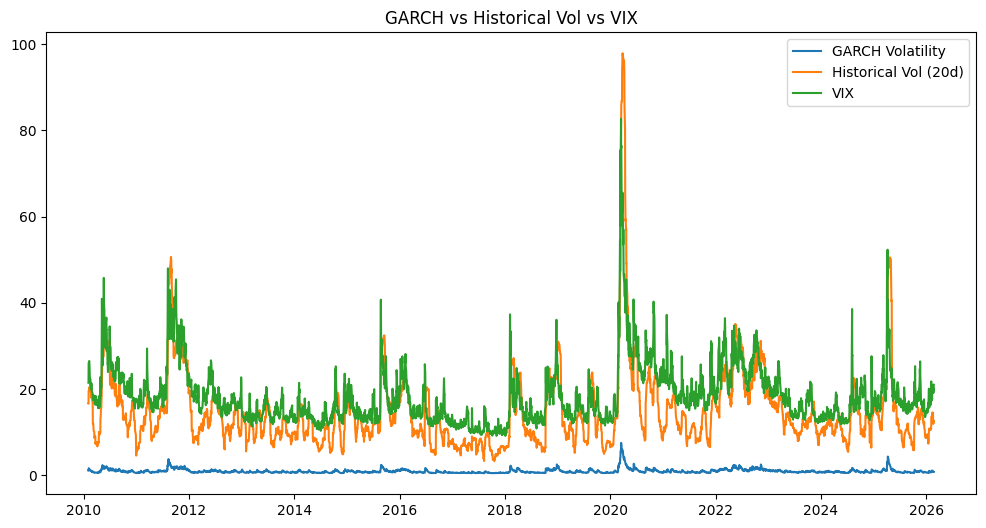

In [91]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["GARCH_Vol"], label="GARCH Volatility")
plt.plot(df["Date"], df["HV_20_Annualized"], label="Historical Vol (20d)")
plt.plot(df["Date"], df["VIX_Close"], label="VIX")

plt.legend()
plt.title("GARCH vs Historical Vol vs VIX")
plt.show()

# Volatility Forecast 

In [92]:
forecast = garch_result.forecast(horizon=1)

variance_forecast = forecast.variance.iloc[-1, 0]
vol_forecast = np.sqrt(variance_forecast)/100

vol_forecast

np.float64(0.008522227276670654)

In [93]:
VaR_95 = -1.65 * vol_forecast
VaR_95

np.float64(-0.014061675006506577)

# Forecast Accuracy

In [94]:
df["GARCH_Var_Forecast"] = ((df["GARCH_Vol"]).shift(1))**2
df["Realized_Variance"] = ((df["GARCH_Vol"]))**2

df = df.dropna()

mse_garch = np.mean(
    (df["GARCH_Var_Forecast"] - df["Realized_Variance"])**2
)

mse_garch

np.float64(0.42655598495771363)

In [95]:
df["Naive_Var"] = df["Realized_Variance"].shift(1)

mse_naive = np.mean(
    (df["Naive_Var"] - df["Realized_Variance"])**2
)

In [96]:
print("GARCH MSE:", mse_garch)
print("Naive MSE:", mse_naive)

GARCH MSE: 0.42655598495771363
Naive MSE: 0.42666159849038504


In [97]:
if mse_garch < mse_naive:
    print("GARCH model is better than Naive model")
else:
    print("Naive model is better or GARCH adds no value")

GARCH model is better than Naive model


In [98]:
# Need to check scale of all value to ensure they are comparable